<a href="https://colab.research.google.com/github/SergeiVKalinin/Research-Projects/blob/main/Batteries/BayesianModellingBatteries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bayesian modeling and hypothesis learning for battery state of health prediction (toy data)

*Notebook by Maxim Ziatdinov (last updated - Jan 9 2023)*

*Funding: ORNL CNMS user program*

Install [GPax](https://github.com/ziatdinovmax/gpax) package:

In [ ]:
!pip install git+https://github.com/ziatdinovmax/gpax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ziatdinovmax/gpax to /tmp/pip-req-build-r67lmi83
  Running command git clone --filter=blob:none --quiet https://github.com/ziatdinovmax/gpax /tmp/pip-req-build-r67lmi83
  Resolved https://github.com/ziatdinovmax/gpax to commit 3b301fad78b7112ae615e39f5d5e21c6169c0f2e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 21.9 MB/s eta 0:00:00
  Created wheel for gpax: filename=gpax-0.0.5-py3-none-any.whl size=36299 sha256=c66c22a06dc5395268554c0f18b3173742057063fd1d321f265f3fd5a1a34d5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xjfkt7wk/wheels/dd/3b/45/0b3ff6e68ec6779c69bdfb22da3ff6c18707ff140d9728d57d
Successfully built gpax


Imports:

In [ ]:
import gpax

from copy import deepcopy as dc

import numpy as np
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
import arviz as az

import matplotlib.pyplot as plt

import warnings

gpax.utils.enable_x64()
warnings.filterwarnings("ignore", category=UserWarning)

First, we define possible models that describe a behavior of interest (based on Table 1 in *Gasper et al. Journal of The Electrochemical Society, 2022 169 080518*). Note that in each case we first write them as deterministic functions and then define probabilistic priors over their parameters as separate functions. Here, most of priors are standard normal reflecting the fact that a person who wrote this notebook (MZ) has very little expertise in this domain. feel free to change them.

In [ ]:
def linear1(x, params):
    return 1 - params["beta1"] * x

def linear1_prior():
    return {
    "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1))
    }


def linear2(x, params):
    return params["beta0"] - params["beta1"] * x

def linear2_prior():
    return {
    "beta0": numpyro.sample("beta0", numpyro.distributions.Normal(0, 1)),
    "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1))
    }


def square_root(x, params):
    return 1 - params["beta1"] * jnp.sqrt(x)

def square_root_prior():
    return {
      "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1))
    }


def power_law1(x, params):
  return 1 - params["beta1"] * jnp.power(x, params["beta2"])

def power_law1_prior():
  return {
    "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1)),
    "beta2": numpyro.sample("beta2", numpyro.distributions.Normal(0, 1))
  }


def power_law2(x, params):
  return params["beta0"] - params["beta1"] * jnp.power(x, params["beta2"])

def power_law2_prior():
    return {
        "beta0": numpyro.sample("beta0", numpyro.distributions.Normal(0, 1)),
        "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1)),
        "beta2": numpyro.sample("beta2", numpyro.distributions.Normal(0, 1))
    }


def exponential1(x, params):
    return params["beta0"] * jnp.exp(params["beta1"] * jnp.power(x, params["beta2"]))

def exponential1_prior():
    return {
        "beta0": numpyro.sample("beta0", numpyro.distributions.Normal(0, 1)),
        "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1)),
        "beta2": numpyro.sample("beta2", numpyro.distributions.Normal(0, 1))
    }


def exponential2(x, params):
    return params["beta0"] * jnp.exp(-jnp.power(x / params["beta1"], params["beta2"]))

def exponential2_prior():
    return {
        "beta0": numpyro.sample("beta0", numpyro.distributions.Normal(0, 1)),
        "beta1": numpyro.sample("beta1", numpyro.distributions.Gamma(2, 2)),
        "beta2": numpyro.sample("beta2", numpyro.distributions.Gamma(2, 2))
    }


def logarithmic(x, params):
    return 1 - params["beta1"] * jnp.log(x)

def logarithmic_prior():
  return {
    "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1))
  }


def sigmoidal(x, params):
    beta1 = params["beta1"]
    beta2 = params["beta2"]
    beta3 = params["beta3"]
    return 1 - 2*beta1 * (0.5 - 1 / (1 + jnp.power(jnp.exp(beta2*x), beta3)))

def sigmoidal_prior():
    return {
        "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1)),
        "beta2": numpyro.sample("beta2", numpyro.distributions.Normal(0, 1)),
        "beta3": numpyro.sample("beta3", numpyro.distributions.Normal(0, 1))
    }

def site_loss(x, params):
    return jnp.sqrt(params["beta0"]**2 - 2*params["beta1"]*params["beta0"]*x)

def site_loss_prior():
    return {
        "beta0": numpyro.sample("beta0", numpyro.distributions.Normal(0, 1)),
        "beta1": numpyro.sample("beta1", numpyro.distributions.Normal(0, 1)),
    }

Now let's generate some synthetic data. In the future, we will substitute it with actual battery simulation data.

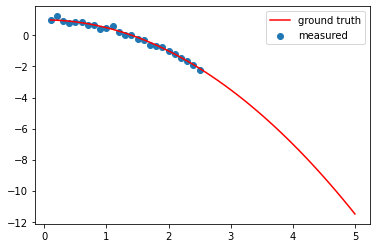

In [ ]:
X = np.linspace(0.1, 5)
y = power_law1(X, {"beta1": 0.5, "beta2": 2})

split = int(0.5 * len(X))
X_measured = X[:split]
X_unmeasured = X[split:]

y_measured = power_law1(X_measured, {"beta1": 0.5, "beta2": 2}) + 0.1*np.random.normal(size=X_measured.shape)

plt.scatter(X_measured, y_measured, label='measured')
plt.plot(X, y, c='red', label='ground truth')
plt.legend()

Now let's run Bayesian inference with each model to determine which one is more likely to explain the data observed so far (```X_measured```).

In [ ]:
model_list = [linear1, linear2, square_root,
              power_law1, power_law2,
              exponential1, exponential2,
              logarithmic, sigmoidal, site_loss]

model_prior_list = [linear1_prior, linear2_prior, square_root_prior,
                    power_law1_prior, power_law2_prior,
                    exponential1_prior, exponential2_prior,
                    logarithmic_prior, sigmoidal_prior, site_loss_prior]

key1, key2 = gpax.utils.get_keys()

mcmc_all = {}
for model, model_prior in zip(model_list, model_prior_list):
    spm = gpax.sPM(model, model_prior)
    spm.fit(key1, X_measured, y_measured)
    mcmc_all[str(model)[10:-19]] = dc(spm.mcmc)

sample: 100%|██████████| 4000/4000 [00:18<00:00, 211.21it/s, 3 steps of size 7.72e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.97      0.05      0.97      0.89      1.06   1514.22      1.00
       sig      0.40      0.06      0.39      0.31      0.50   1494.64      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:11<00:00, 355.38it/s, 7 steps of size 3.09e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0      1.57      0.10      1.57      1.39      1.73    710.24      1.00
     beta1      1.31      0.07      1.31      1.18      1.41    708.89      1.00
       sig      0.26      0.04      0.26      0.20      0.32    751.80      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:08<00:00, 491.97it/s, 3 steps of size 8.80e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      1.17      0.12      1.18      0.97      1.36   1823.07      1.00
       sig      0.68      0.10      0.67      0.52      0.84   1461.36      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:08<00:00, 460.13it/s, 7 steps of size 1.99e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.53      0.03      0.53      0.48      0.58    575.37      1.00
     beta2      1.95      0.07      1.95      1.82      2.06    604.93      1.00
       sig      0.11      0.02      0.11      0.08      0.14    637.79      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:08<00:00, 457.66it/s, 1 steps of size 2.06e-01. acc. prob=0.66]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.51      1.24     -0.99     -2.16      1.28      3.89      1.49
     beta1     -0.49      1.01     -0.80     -1.85      1.11      4.23      1.45
     beta2      0.10      0.90     -0.38     -0.63      1.67      3.41      1.56
       sig      0.63      0.26      0.70      0.23      0.91      4.10      1.45

Number of divergences: 325


sample: 100%|██████████| 4000/4000 [00:09<00:00, 432.92it/s, 7 steps of size 4.32e-01. acc. prob=0.84]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -1.18      0.85     -1.30     -2.67     -0.07     83.21      1.01
     beta1     -1.58      0.81     -1.65     -2.98     -0.52     56.61      1.01
     beta2     -1.28      1.20     -1.55     -2.66      1.30     61.62      1.00
       sig      0.82      0.16      0.79      0.59      1.07    137.98      1.00

Number of divergences: 98


sample: 100%|██████████| 4000/4000 [00:09<00:00, 427.97it/s, 7 steps of size 4.96e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0      0.89      0.57      0.93     -0.17      1.71    866.48      1.00
     beta1      0.77      0.39      0.72      0.19      1.30   1224.97      1.00
     beta2      1.46      0.80      1.35      0.21      2.60    858.08      1.00
       sig      0.94      0.16      0.92      0.69      1.17   1274.15      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:07<00:00, 512.43it/s, 3 steps of size 9.26e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.94      0.31      0.94      0.39      1.43   1933.19      1.00
       sig      1.30      0.20      1.28      0.97      1.60   1607.13      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:09<00:00, 442.64it/s, 31 steps of size 9.93e-02. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1     -3.07      0.57     -3.00     -3.95     -2.13    405.69      1.00
     beta2     -0.96      0.50     -0.84     -1.70     -0.30    470.28      1.00
     beta3      0.93      0.45      0.85      0.23      1.53    398.14      1.00
       sig      0.50      0.09      0.49      0.38      0.64    551.60      1.00

Number of divergences: 2


sample: 100%|██████████| 4000/4000 [00:08<00:00, 461.94it/s, 1 steps of size 7.06e-02. acc. prob=0.59]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.01      0.06      0.00     -0.15      0.06     12.84      1.00
     beta1     -0.08      0.46     -0.02     -0.95      0.54      8.02      1.00
       sig      1.04      0.16      0.98      0.85      1.33      6.62      1.18

Number of divergences: 1942


In [ ]:
mcmc_all

{'linear1': <numpyro.infer.mcmc.MCMC at 0x7f61b8a638b0>,
 'linear2': <numpyro.infer.mcmc.MCMC at 0x7f61b68c1310>,
 'square_root': <numpyro.infer.mcmc.MCMC at 0x7f61b5e20070>,
 'power_law1': <numpyro.infer.mcmc.MCMC at 0x7f61b68e08e0>,
 'power_law2': <numpyro.infer.mcmc.MCMC at 0x7f61b5c212e0>,
 'exponential1': <numpyro.infer.mcmc.MCMC at 0x7f61b5914dc0>,
 'exponential2': <numpyro.infer.mcmc.MCMC at 0x7f61b575d970>,
 'logarithmic': <numpyro.infer.mcmc.MCMC at 0x7f61b5a2b430>,
 'sigmoidal': <numpyro.infer.mcmc.MCMC at 0x7f61b5717bb0>,
 'site_loss': <numpyro.infer.mcmc.MCMC at 0x7f61b50dfd90>}

In [ ]:
az.compare(mcmc_all, ic="waic")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
power_law1,0,19.355276,2.502742,0.000000,1.000000e+00,4.196094,0.000000,True,log
linear2,1,-2.622241,2.854727,21.977517,0.000000e+00,3.455577,4.953671,True,log
linear1,2,-12.862181,1.693043,32.217457,0.000000e+00,2.807838,4.301446,True,log
sigmoidal,3,-18.403295,2.058143,37.758571,0.000000e+00,3.437434,5.076890,True,log
power_law2,4,-25.212937,13.701148,44.568213,0.000000e+00,3.429065,5.567280,True,log
square_root,5,-26.117143,1.546402,45.472419,0.000000e+00,2.669499,4.658040,True,log
exponential1,6,-30.947063,2.595283,50.302339,0.000000e+00,2.176510,4.156947,True,log
exponential2,7,-34.640299,1.855703,53.995574,0.000000e+00,4.157171,6.156771,True,log
site_loss,8,-37.272344,0.778180,56.627620,0.000000e+00,3.532092,5.618899,False,log
logarithmic,9,-43.360291,2.476827,62.715567,1.696719e-10,3.021322,5.457184,True,log


Make a prediction with the best model:

In [ ]:
spm = gpax.sPM(power_law1, power_law1_prior)
spm.fit(key1, X_measured, y_measured)
mean, samples = spm.predict(key2, X_unmeasured)

sample: 100%|██████████| 4000/4000 [00:08<00:00, 462.83it/s, 7 steps of size 1.99e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.53      0.03      0.53      0.48      0.58    575.37      1.00
     beta2      1.95      0.07      1.95      1.82      2.06    604.93      1.00
       sig      0.11      0.02      0.11      0.08      0.14    637.79      1.00

Number of divergences: 0


Plot results. Note that the dispersion in sampled predictions is effectively a predictive uncertainty

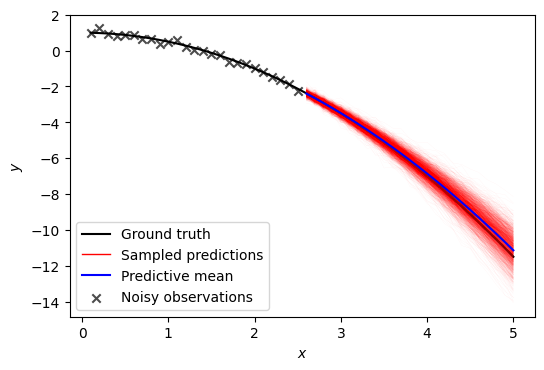

In [ ]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X_measured, y_measured, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
ax.plot(X, y, c='black', zorder=0, label="Ground truth")
for y1 in samples:
    ax.plot(X_unmeasured, y1, lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_unmeasured, samples[0], lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_unmeasured, mean, lw=1.5, zorder=1, c='b', label='Predictive mean')
ax.legend(loc='best')
l.set_alpha(0)

Now let's assume that a physical mechanism defining the behavior of interest changes over time

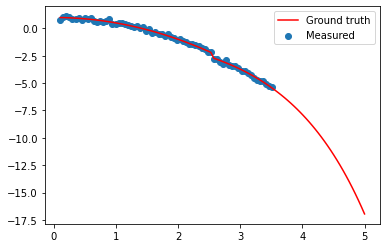

In [ ]:
X = np.linspace(0.1, 5, 100)

split = int(0.5 * len(X))
X1 = X[:split]
X2 = X[split:]
y1 = power_law1(X1, {"beta1": 0.5, "beta2": 2})
y2 = exponential1(X2, {"beta0": -.5, "beta1": 0.6, "beta2": 1.1})
y = np.concatenate((y1, y2), axis=0)

X_measured = X[:split+20]
X_unmeasured = X[split+20:]
y_measured = y[:len(X_measured)] + 0.1*np.random.normal(size=X_measured.shape)
y_unmeasured = y[len(X_measured):]

plt.scatter(X_measured, y_measured, label='Measured')
plt.plot(X, y, c='red', label='Ground truth')
plt.legend()

Run Bayesian inference with each model, same as before:

In [ ]:
model_list = [linear1, linear2, square_root,
              power_law1, power_law2,
              exponential1, exponential2,
              logarithmic, sigmoidal, site_loss]

model_prior_list = [linear1_prior, linear2_prior, square_root_prior,
                    power_law1_prior, power_law2_prior,
                    exponential1_prior, exponential2_prior,
                    logarithmic_prior, sigmoidal_prior, site_loss_prior]

key1, key2 = gpax.utils.get_keys()

mcmc_all = {}
for model, model_prior in zip(model_list, model_prior_list):
    spm = gpax.sPM(model, model_prior)
    spm.fit(key1, X_measured, y_measured)
    mcmc_all[str(model)[10:-19]] = dc(spm.mcmc)

sample: 100%|██████████| 4000/4000 [00:08<00:00, 493.27it/s, 3 steps of size 1.01e+00. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      1.38      0.05      1.38      1.30      1.46   2019.74      1.00
       sig      0.80      0.07      0.79      0.67      0.90   1964.45      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:09<00:00, 433.51it/s, 7 steps of size 3.60e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0      2.16      0.13      2.17      1.94      2.35    746.68      1.00
     beta1      1.88      0.06      1.88      1.78      1.98    807.21      1.00
       sig      0.53      0.05      0.52      0.46      0.60   1016.33      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:08<00:00, 486.47it/s, 3 steps of size 9.21e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      1.95      0.12      1.96      1.75      2.14   1988.79      1.00
       sig      1.32      0.11      1.31      1.14      1.50   1919.06      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:09<00:00, 417.93it/s, 31 steps of size 1.50e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.50      0.01      0.50      0.47      0.52    587.48      1.00
     beta2      2.05      0.03      2.05      2.01      2.09    577.13      1.00
       sig      0.14      0.01      0.14      0.12      0.16    784.43      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:10<00:00, 384.18it/s, 31 steps of size 7.44e-02. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0      1.00      0.04      1.00      0.94      1.06    623.32      1.00
     beta1      0.50      0.03      0.50      0.45      0.54    547.88      1.00
     beta2      2.05      0.04      2.05      1.98      2.12    547.13      1.00
       sig      0.14      0.01      0.14      0.12      0.16    852.72      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:13<00:00, 297.85it/s, 63 steps of size 1.96e-02. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.03      0.02     -0.03     -0.06     -0.01    192.24      1.01
     beta1      2.26      0.52      2.24      1.43      3.13    160.08      1.00
     beta2      0.71      0.11      0.70      0.53      0.87    211.94      1.01
       sig      0.63      0.06      0.62      0.53      0.72    407.68      1.00

Number of divergences: 19


sample: 100%|██████████| 4000/4000 [00:09<00:00, 407.67it/s, 7 steps of size 4.85e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -1.80      0.82     -1.90     -3.07     -0.59    532.00      1.00
     beta1      1.32      0.88      1.14      0.16      2.45   1021.94      1.00
     beta2      0.20      0.35      0.10      0.00      0.40    389.91      1.00
       sig      2.12      0.21      2.11      1.76      2.42   1254.66      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:08<00:00, 493.04it/s, 3 steps of size 1.01e+00. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      2.47      0.25      2.48      2.06      2.87   2040.11      1.00
       sig      1.86      0.16      1.85      1.58      2.10   1899.23      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:11<00:00, 351.02it/s, 63 steps of size 5.47e-02. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1     -5.40      0.58     -5.36     -6.34     -4.45    513.80      1.00
     beta2     -0.87      0.51     -0.73     -1.57     -0.22    234.68      1.00
     beta3      0.88      0.49      0.78      0.18      1.59    340.38      1.00
       sig      1.02      0.11      1.01      0.85      1.18    648.08      1.00

Number of divergences: 6


sample: 100%|██████████| 4000/4000 [00:08<00:00, 447.52it/s, 1 steps of size 9.40e-02. acc. prob=0.61] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.04      0.14     -0.01     -0.25      0.22     29.87      1.01
     beta1      0.00      0.03     -0.00     -0.03      0.06     20.98      1.07
       sig      2.36      0.24      2.39      1.95      2.73     12.10      1.11

Number of divergences: 1933


Compare models:

In [ ]:
az.compare(mcmc_all, ic="waic")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
power_law1,0,39.614272,2.887605,0.000000,1.000000e+00,6.671349,0.000000,True,log
power_law2,1,38.592137,3.712764,1.022135,4.735830e-09,6.593135,0.232969,True,log
linear2,2,-55.579546,2.674483,95.193819,1.067191e-09,4.186649,7.855850,True,log
exponential1,3,-66.363531,1.463345,105.977803,8.551226e-10,4.214172,7.428130,False,log
linear1,4,-83.964717,1.596326,123.578989,5.947335e-10,3.427523,7.886465,False,log
sigmoidal,5,-100.892477,1.924657,140.506750,4.163979e-10,4.806986,8.493998,False,log
square_root,6,-119.541632,1.538215,159.155905,2.265818e-10,3.861130,8.056692,False,log
logarithmic,7,-145.367757,4.347282,184.982029,9.641657e-11,8.008715,9.995409,True,log
exponential2,8,-152.802208,1.577811,192.416480,2.732251e-11,5.529686,8.465048,False,log
site_loss,9,-161.258482,1.921580,200.872754,0.000000e+00,6.539924,8.917330,False,log


Make a prediction using the "best" mdoel:

In [ ]:
spm = gpax.sPM(power_law1, power_law1_prior)
spm.fit(key1, X_measured, y_measured)
mean, samples = spm.predict(key2, X_unmeasured)

sample: 100%|██████████| 4000/4000 [00:09<00:00, 422.79it/s, 31 steps of size 1.50e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.50      0.01      0.50      0.47      0.52    587.48      1.00
     beta2      2.05      0.03      2.05      2.01      2.09    577.13      1.00
       sig      0.14      0.01      0.14      0.12      0.16    784.43      1.00

Number of divergences: 0


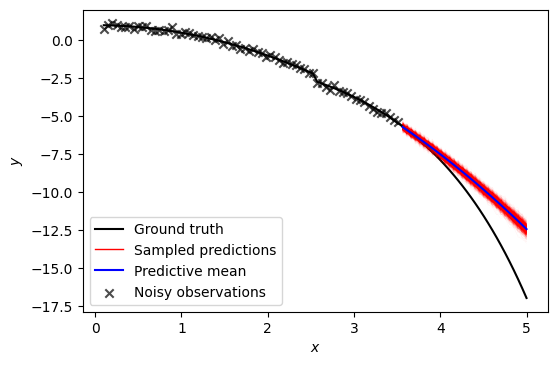

In [ ]:
# Plot results
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X_measured, y_measured, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
ax.plot(X, y, c='black', zorder=0, label="Ground truth")
for y1 in samples:
    ax.plot(X_unmeasured, y1, lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_unmeasured, samples[0], lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_unmeasured, mean, lw=1.5, zorder=1, c='b', label='Predictive mean')
ax.legend(loc='best')
l.set_alpha(0)

Clearly, the prediction isn't very good (note, by the way, that in realistic or even digital twin settings we won't have the ground truth for the "unmeasured" part).

Let's see if we can use the results of WAIC to select a subset of models (hypotheses) and actively learn which one is the correct one on the "unmeasured" part.

First, let's define some helper function. For more details about hypothesis learning, see [this paper](https://onlinelibrary.wiley.com/doi/10.1002/adma.202201345?af=R).

In [ ]:
def get_best_model(record):
    return record[:,1].argmax()

def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record

def get_reward(obj_history, obj):
    """A reward of +/-1 is given if the median uncertainty at the current step
    is smaller/larger than the median uncertainty at the previous step"""
    if jnp.nanmedian(obj) < obj_history[-1]:  # one can use integral uncertainty instead of median
        r = 1
    else:
        r = -1
    return r

def step(model, model_prior, X_measured, y_measured, X_unmeasured=None,
         gp_wrap=False, num_restarts=1, gp_kernel_prior=None, **kwargs):
    """Compute model posterior and use it to derive acqusition function"""
    verbose = kwargs.get("print_summary", True)
    sgr = numpyro.diagnostics.split_gelman_rubin
    for i in range(num_restarts):
        rng_key, rng_key_predict = gpax.utils.get_keys(i)
        # Get/update model posterior
        if gp_wrap:  # wrap model into a gaussian process (gives more flexibility)
            model = gpax.ExactGP(
                1, 'Matern', kernel_prior=gp_kernel_prior,
                mean_fn=model, mean_fn_prior=model_prior)
            model.fit(
                rng_key, X_measured, y_measured, num_warmup=2000,
                num_samples=2000, num_chains=1, print_summary=verbose)
        else:  # use a standalone model
            model = gpax.sPM(model, model_prior)
            model.fit(rng_key, X_measured, y_measured, num_warmup=2000,
                num_samples=2000, num_chains=1, print_summary=verbose)
        rhats = [sgr(v).item() for (k,v) in model.get_samples(1).items() if k != 'mu']
        if max(rhats) < 1.1:
            break
    # Compute acquisition function
    obj = 0
    if X_unmeasured is not None:
        mean, samples = model.predict(rng_key, X_unmeasured)
        obj = samples.squeeze().var(0)
    return obj, model

def update_datapoints(point_idx, point_measured, X_meas, y_meas, X_unmeas, y_unmeas):
    """Update "measured" dummy data points"""
    X_meas = jnp.append(X_meas, X_unmeas[point_idx])
    X_unmeas = jnp.delete(X_unmeas, point_idx)
    y_meas = jnp.append(y_meas, point_measured)
    y_unmeas = jnp.delete(y_unmeas, point_idx)
    return X_meas, y_meas, X_unmeas, y_unmeas

We will work only with the "unmeasured" part, but we'll need a few points to initalize it:

In [ ]:
idx = np.random.randint(0, len(y_unmeasured), 3)
X_measured = X_unmeasured[idx]
y_measured = y_unmeasured[idx]
X_unmeasured = np.delete(X_unmeasured, idx)
y_unmeasured = np.delete(y_unmeasured, idx)

print(X_measured.shape, X_unmeasured.shape)

(3,) (27,)


Run the hypothesis learning algorithm:

In [ ]:
exploration_steps = 15
eps = 0.4  # epsilon in epsilon-greedy algorithm
warmup_steps = 5
models = [power_law1, power_law2, linear2, exponential1, linear1]
model_priors = [power_law1_prior, power_law2_prior, linear2_prior, exponential1_prior, linear1_prior]

np.random.seed(1)  # rng seed for epsilon-greedy sampling
record = np.zeros((len(models), 2))
model_choices = []
obj_history = []
# Warm-up phase
for w in range(warmup_steps):
    print("\nWarmup step {}/{}".format(w+1, warmup_steps))
    obj_median_all, obj_all = [], []
    # Iterate over probabilistic models in the list
    for i, model in enumerate(models):
        # for each model, run BI and store uncertainty values
        obj, _ = step(model, model_priors[i], X_measured, y_measured, X_unmeasured)
        record[i, 0] += 1
        obj_all.append(obj)
        obj_median_all.append(jnp.nanmedian(obj).item())  # one can use integral uncertainty instead of median
    # 'Reward' a model that has the smallest integral/median uncertainty
    idx = np.argmin(obj_median_all)
    model_choices.append(idx)
    record[idx, 1] += 1
    # Store the integral/median uncertainty
    obj_history.append(obj_median_all[idx])
    # Compute the next measurement point using the predictive uncertainty of rewarded model
    obj = obj_all[idx]
    next_point_idx = obj.argmax()
    # Evaluate the function in the suggested point
    measured_point = y_unmeasured[next_point_idx] + 0.1*np.random.normal()
    # Update training/test data
    X_measured, y_measured, X_unmeasured, y_unmeasured = update_datapoints(
        next_point_idx, measured_point, X_measured, y_measured, X_unmeasured, y_unmeasured)
    # Print running rewards
    print('\n')
    for i, r in enumerate(record):
        print('model: {:<15} counts: {:<6} reward (avg): {:<3}'.format(str(models[i])[10:-19], (int(r[0])), np.round(r[1]/(w+1), 3)))
# Average over the number of warmup steps
record[:, 1] = record[:, 1] / warmup_steps

# Run exploration
for e in range(exploration_steps - warmup_steps):
    print("\nExploration step {}/{}".format(e+warmup_steps+1, exploration_steps))
    # Choose model according to epsilon-greedy policy
    if np.random.random() > eps:
        idx = get_best_model(record)
    else:
        idx = np.random.randint(len(models))
    model_choices.append(idx)
    print("Using model {}".format(idx+1))
    # Derive acqusition function with the selected model
    obj, m_post = step(models[idx], model_priors[idx], X_measured, y_measured, X_unmeasured)
    # Get reward
    r = get_reward(obj_history, obj)
    # Update records
    record = update_record(record, idx, r)
    obj_history.append(jnp.nanmedian(obj).item())
    # Evaluate function in the suggested point
    next_point_idx = obj.argmax()
    measured_point = y_unmeasured[next_point_idx] + 0.1*np.random.normal()
    # Update training/test data
    X_measured, y_measured, X_unmeasured, y_unmeasured = update_datapoints(
        next_point_idx, measured_point, X_measured, y_measured, X_unmeasured, y_unmeasured)
    # Print running rewards
    print('\n')
    for i, r in enumerate(record):
        print("model {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), np.round(r[1], 3)))


Warmup step 1/5


sample: 100%|██████████| 4000/4000 [00:08<00:00, 480.56it/s, 23 steps of size 5.84e-02. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.92      0.52      0.82      0.23      1.62    113.54      1.00
     beta2      1.82      0.41      1.80      1.24      2.56     71.58      1.00
       sig      1.82      1.45      1.38      0.60      3.32    207.00      1.00

Number of divergences: 95


sample: 100%|██████████| 4000/4000 [00:08<00:00, 451.97it/s, 45 steps of size 4.47e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0      0.12      1.04      0.13     -1.55      1.90    576.06      1.00
     beta1      1.00      0.56      0.90      0.26      1.87    487.16      1.00
     beta2      1.66      0.46      1.66      1.04      2.36    215.04      1.00
       sig      2.11      1.60      1.68      0.64      3.52    180.52      1.00

Number of divergences: 36


sample: 100%|██████████| 4000/4000 [00:08<00:00, 483.75it/s, 15 steps of size 4.10e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.39      0.98     -0.36     -1.92      1.30   1107.08      1.00
     beta1      2.05      0.54      2.13      1.20      2.83    464.44      1.00
       sig      2.92      1.72      2.40      1.07      5.08    451.62      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:12<00:00, 323.30it/s, 127 steps of size 3.97e-03. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.67      0.41     -0.60     -1.22     -0.09    244.65      1.00
     beta1      0.70      0.39      0.61      0.14      1.23    236.38      1.01
     beta2      1.06      0.30      1.06      0.61      1.58    246.56      1.00
       sig      0.86      0.76      0.63      0.17      1.76    139.99      1.00

Number of divergences: 58


sample: 100%|██████████| 4000/4000 [00:07<00:00, 523.01it/s, 7 steps of size 4.20e-01. acc. prob=0.84]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      2.33      0.53      2.45      1.53      3.02    478.56      1.00
       sig      3.00      1.90      2.42      1.02      5.54    452.32      1.00

Number of divergences: 0


model: power_law1      counts: 1      reward (avg): 0.0
model: power_law2      counts: 1      reward (avg): 0.0
model: linear2         counts: 1      reward (avg): 0.0
model: exponential1    counts: 1      reward (avg): 1.0
model: linear1         counts: 1      reward (avg): 0.0

Warmup step 2/5


sample: 100%|██████████| 4000/4000 [00:09<00:00, 442.03it/s, 31 steps of size 6.29e-02. acc. prob=0.70]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.77      0.45      0.66      0.24      1.46     61.96      1.03
     beta2      1.99      0.37      1.98      1.43      2.54     39.45      1.04
       sig      1.63      0.88      1.39      0.71      2.61     67.95      1.04

Number of divergences: 172


sample: 100%|██████████| 4000/4000 [00:08<00:00, 449.75it/s, 255 steps of size 2.40e-02. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0      0.42      1.00      0.47     -1.21      2.02    480.76      1.00
     beta1      0.74      0.50      0.60      0.14      1.49    252.21      1.00
     beta2      2.01      0.46      2.01      1.26      2.70    198.94      1.01
       sig      1.75      1.24      1.46      0.51      3.07    238.64      1.00

Number of divergences: 82


sample: 100%|██████████| 4000/4000 [00:08<00:00, 478.36it/s, 15 steps of size 4.40e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.43      0.96     -0.43     -1.99      1.17   1092.73      1.00
     beta1      2.28      0.52      2.37      1.51      3.06    293.56      1.00
       sig      3.25      1.67      2.81      1.32      5.21    321.65      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:09<00:00, 428.19it/s, 3 steps of size 5.39e-03. acc. prob=0.44]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.39      0.25     -0.28     -0.84     -0.15     14.76      1.28
     beta1      0.84      0.25      0.94      0.25      0.98     44.85      1.19
     beta2      0.98      0.17      0.92      0.83      1.37     49.03      1.18
       sig      0.30      0.42      0.14      0.12      0.63     21.46      1.18

Number of divergences: 397


sample: 100%|██████████| 4000/4000 [00:07<00:00, 515.94it/s, 7 steps of size 4.67e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      2.59      0.47      2.68      1.96      3.25    378.26      1.00
       sig      3.14      1.68      2.68      1.16      5.15    393.59      1.00

Number of divergences: 0


model: power_law1      counts: 2      reward (avg): 0.0
model: power_law2      counts: 2      reward (avg): 0.0
model: linear2         counts: 2      reward (avg): 0.0
model: exponential1    counts: 2      reward (avg): 1.0
model: linear1         counts: 2      reward (avg): 0.0

Warmup step 3/5


sample: 100%|██████████| 4000/4000 [00:08<00:00, 453.88it/s, 7 steps of size 5.93e-03. acc. prob=0.64]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.22      0.20      0.15      0.09      0.41     89.27      1.04
     beta2      2.81      0.34      2.96      2.24      3.17     57.75      1.07
       sig      0.51      0.46      0.34      0.20      1.06     45.54      1.08

Number of divergences: 115


sample: 100%|██████████| 4000/4000 [00:08<00:00, 447.57it/s, 5 steps of size 1.93e-02. acc. prob=0.35]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0      0.64      0.61      0.71     -0.22      1.60     57.90      1.05
     beta1      0.29      0.28      0.19      0.13      0.62     14.77      1.13
     beta2      2.65      0.39      2.80      1.98      3.01      8.61      1.21
       sig      0.83      0.59      0.57      0.49      1.60     12.70      1.12

Number of divergences: 535


sample: 100%|██████████| 4000/4000 [00:08<00:00, 462.23it/s, 15 steps of size 4.13e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.36      0.97     -0.35     -2.01      1.18    812.35      1.00
     beta1      2.28      0.42      2.33      1.62      2.94    720.88      1.00
       sig      3.02      1.21      2.74      1.48      4.68    742.03      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:11<00:00, 358.95it/s, 45 steps of size 2.62e-03. acc. prob=0.79] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.51      0.33     -0.44     -0.99     -0.12     72.85      1.00
     beta1      0.75      0.37      0.70      0.26      1.25     57.66      1.00
     beta2      1.06      0.22      1.03      0.76      1.39     67.52      1.00
       sig      0.21      0.18      0.15      0.07      0.40    134.14      1.01

Number of divergences: 166


sample: 100%|██████████| 4000/4000 [00:07<00:00, 516.93it/s, 5 steps of size 5.42e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      2.57      0.35      2.62      2.05      3.08    449.19      1.00
       sig      2.94      1.28      2.60      1.33      4.56    518.58      1.00

Number of divergences: 0


model: power_law1      counts: 3      reward (avg): 0.0
model: power_law2      counts: 3      reward (avg): 0.0
model: linear2         counts: 3      reward (avg): 0.0
model: exponential1    counts: 3      reward (avg): 1.0
model: linear1         counts: 3      reward (avg): 0.0

Warmup step 4/5


sample: 100%|██████████| 4000/4000 [00:09<00:00, 438.54it/s, 7 steps of size 2.59e-03. acc. prob=0.91]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.16      0.13      0.13      0.09      0.19     71.04      1.02
     beta2      3.01      0.24      3.05      2.78      3.29     86.81      1.02
       sig      0.38      0.33      0.31      0.14      0.62     89.27      1.02

Number of divergences: 20


sample: 100%|██████████| 4000/4000 [00:09<00:00, 435.57it/s, 49 steps of size 1.78e-02. acc. prob=0.68]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0      1.04      1.05      1.04     -0.70      2.69     58.59      1.00
     beta1      0.31      0.23      0.24      0.10      0.54    173.84      1.01
     beta2      2.59      0.34      2.66      2.01      3.06    180.32      1.01
       sig      0.90      0.61      0.73      0.30      1.57    158.68      1.00

Number of divergences: 241


sample: 100%|██████████| 4000/4000 [00:08<00:00, 478.64it/s, 15 steps of size 4.59e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.36      0.95     -0.37     -1.86      1.26   1099.51      1.00
     beta1      2.46      0.38      2.49      1.88      3.10    654.10      1.00
       sig      3.16      1.11      2.94      1.69      4.65    697.87      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:11<00:00, 354.84it/s, 99 steps of size 2.13e-03. acc. prob=0.87]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.57      0.32     -0.51     -1.03     -0.11    104.53      1.00
     beta1      0.67      0.34      0.60      0.19      1.21    103.76      1.00
     beta2      1.11      0.22      1.10      0.76      1.44    102.02      1.00
       sig      0.17      0.11      0.13      0.07      0.29    211.66      1.00

Number of divergences: 57


sample: 100%|██████████| 4000/4000 [00:07<00:00, 505.62it/s, 5 steps of size 5.90e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      2.76      0.33      2.80      2.30      3.24    536.48      1.00
       sig      3.05      1.17      2.77      1.59      4.51    589.91      1.00

Number of divergences: 0


model: power_law1      counts: 4      reward (avg): 0.0
model: power_law2      counts: 4      reward (avg): 0.0
model: linear2         counts: 4      reward (avg): 0.0
model: exponential1    counts: 4      reward (avg): 1.0
model: linear1         counts: 4      reward (avg): 0.0

Warmup step 5/5


sample: 100%|██████████| 4000/4000 [00:08<00:00, 456.17it/s, 127 steps of size 2.89e-02. acc. prob=0.74]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      0.13      0.02      0.13      0.10      0.17    263.41      1.01
     beta2      3.05      0.10      3.06      2.87      3.20    309.07      1.01
       sig      0.31      0.14      0.27      0.16      0.47    193.10      1.00

Number of divergences: 49


sample: 100%|██████████| 4000/4000 [00:09<00:00, 424.98it/s, 5 steps of size 1.06e-02. acc. prob=0.77] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0      0.95      0.78      0.88     -0.17      2.28    201.71      1.03
     beta1      0.14      0.06      0.13      0.06      0.22    151.53      1.04
     beta2      3.06      0.23      3.06      2.60      3.37    106.58      1.05
       sig      0.34      0.15      0.29      0.17      0.53    235.63      1.00

Number of divergences: 112


sample: 100%|██████████| 4000/4000 [00:08<00:00, 476.79it/s, 15 steps of size 5.37e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.31      0.98     -0.30     -1.81      1.42   1168.37      1.00
     beta1      2.42      0.37      2.44      1.81      3.00    895.56      1.00
       sig      3.11      0.97      2.92      1.78      4.51   1011.08      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:11<00:00, 339.27it/s, 63 steps of size 2.81e-03. acc. prob=0.76] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.53      0.25     -0.48     -0.92     -0.16    102.98      1.01
     beta1      0.67      0.28      0.63      0.28      1.11    100.83      1.00
     beta2      1.09      0.18      1.07      0.81      1.37    101.49      1.01
       sig      0.16      0.07      0.14      0.09      0.24    150.79      1.00

Number of divergences: 144


sample: 100%|██████████| 4000/4000 [00:08<00:00, 490.00it/s, 7 steps of size 6.26e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      2.71      0.29      2.74      2.32      3.16    734.46      1.00
       sig      3.00      1.00      2.78      1.78      4.42    688.59      1.00

Number of divergences: 0


model: power_law1      counts: 5      reward (avg): 0.0
model: power_law2      counts: 5      reward (avg): 0.0
model: linear2         counts: 5      reward (avg): 0.0
model: exponential1    counts: 5      reward (avg): 1.0
model: linear1         counts: 5      reward (avg): 0.0

Exploration step 6/15
Using model 4


sample: 100%|██████████| 4000/4000 [00:11<00:00, 333.74it/s, 43 steps of size 1.94e-03. acc. prob=0.82]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.46      0.24     -0.42     -0.81     -0.10    128.83      1.00
     beta1      0.74      0.31      0.70      0.30      1.24    137.17      1.00
     beta2      1.05      0.18      1.03      0.77      1.33    129.87      1.00
       sig      0.13      0.05      0.12      0.07      0.20    273.98      1.01

Number of divergences: 98


model 1:  counts 5  reward (avg) 0.0
model 2:  counts 5  reward (avg) 0.0
model 3:  counts 5  reward (avg) 0.0
model 4:  counts 6  reward (avg) 1.0
model 5:  counts 5  reward (avg) 0.0

Exploration step 7/15
Using model 4


sample: 100%|██████████| 4000/4000 [00:12<00:00, 324.72it/s, 127 steps of size 2.25e-03. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.61      0.28     -0.56     -1.03     -0.15    130.11      1.00
     beta1      0.60      0.28      0.55      0.18      1.00    126.98      1.00
     beta2      1.14      0.20      1.13      0.84      1.48    127.94      1.00
       sig      0.16      0.06      0.14      0.07      0.23    344.91      1.00

Number of divergences: 35


model 1:  counts 5  reward (avg) 0.0
model 2:  counts 5  reward (avg) 0.0
model 3:  counts 5  reward (avg) 0.0
model 4:  counts 7  reward (avg) 0.714
model 5:  counts 5  reward (avg) 0.0

Exploration step 8/15
Using model 3


sample: 100%|██████████| 4000/4000 [00:08<00:00, 452.23it/s, 7 steps of size 4.82e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.16      0.96     -0.17     -1.71      1.49   1087.48      1.00
     beta1      2.43      0.32      2.44      1.87      2.90   1060.98      1.00
       sig      3.20      0.82      3.05      1.97      4.33   1155.47      1.00

Number of divergences: 0


model 1:  counts 5  reward (avg) 0.0
model 2:  counts 5  reward (avg) 0.0
model 3:  counts 6  reward (avg) -0.167
model 4:  counts 7  reward (avg) 0.714
model 5:  counts 5  reward (avg) 0.0

Exploration step 9/15
Using model 4


sample: 100%|██████████| 4000/4000 [00:13<00:00, 299.55it/s, 127 steps of size 2.04e-03. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.60      0.27     -0.58     -1.00     -0.15    103.11      1.00
     beta1      0.60      0.28      0.54      0.21      1.00     88.90      1.00
     beta2      1.14      0.19      1.14      0.83      1.44     98.14      1.00
       sig      0.12      0.04      0.12      0.07      0.17    403.68      1.00

Number of divergences: 10


model 1:  counts 5  reward (avg) 0.0
model 2:  counts 5  reward (avg) 0.0
model 3:  counts 6  reward (avg) -0.167
model 4:  counts 8  reward (avg) 0.75
model 5:  counts 5  reward (avg) 0.0

Exploration step 10/15
Using model 4


sample: 100%|██████████| 4000/4000 [00:14<00:00, 273.84it/s, 127 steps of size 1.80e-03. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.50      0.25     -0.46     -0.86     -0.10     94.72      1.00
     beta1      0.71      0.31      0.66      0.22      1.17     96.61      1.01
     beta2      1.07      0.18      1.05      0.77      1.35     94.55      1.00
       sig      0.14      0.04      0.13      0.08      0.19    327.27      1.00

Number of divergences: 16


model 1:  counts 5  reward (avg) 0.0
model 2:  counts 5  reward (avg) 0.0
model 3:  counts 6  reward (avg) -0.167
model 4:  counts 9  reward (avg) 0.556
model 5:  counts 5  reward (avg) 0.0

Exploration step 11/15
Using model 4


sample: 100%|██████████| 4000/4000 [00:13<00:00, 294.43it/s, 127 steps of size 1.78e-03. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.51      0.25     -0.48     -0.90     -0.11     95.64      1.00
     beta1      0.70      0.31      0.64      0.25      1.13     81.08      1.00
     beta2      1.07      0.18      1.06      0.77      1.37     88.94      1.00
       sig      0.13      0.03      0.12      0.08      0.18    467.48      1.00

Number of divergences: 3


model 1:  counts 5  reward (avg) 0.0
model 2:  counts 5  reward (avg) 0.0
model 3:  counts 6  reward (avg) -0.167
model 4:  counts 10  reward (avg) 0.6
model 5:  counts 5  reward (avg) 0.0

Exploration step 12/15
Using model 2


sample: 100%|██████████| 4000/4000 [00:11<00:00, 349.09it/s, 91 steps of size 3.34e-03. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.81      0.82     -0.92     -2.04      0.43    171.42      1.03
     beta1      0.06      0.04      0.05      0.02      0.11    187.10      1.02
     beta2      3.58      0.31      3.60      3.08      4.06    170.09      1.03
       sig      0.20      0.07      0.19      0.11      0.30    232.78      1.01

Number of divergences: 53


model 1:  counts 5  reward (avg) 0.0
model 2:  counts 6  reward (avg) -0.167
model 3:  counts 6  reward (avg) -0.167
model 4:  counts 10  reward (avg) 0.6
model 5:  counts 5  reward (avg) 0.0

Exploration step 13/15
Using model 4


sample: 100%|██████████| 4000/4000 [00:20<00:00, 195.80it/s, 127 steps of size 2.10e-03. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.58      0.27     -0.54     -0.95     -0.13     93.62      1.00
     beta1      0.62      0.27      0.58      0.20      0.99    112.00      1.00
     beta2      1.12      0.18      1.11      0.78      1.40     96.66      1.00
       sig      0.13      0.03      0.12      0.09      0.18    376.66      1.00

Number of divergences: 23


model 1:  counts 5  reward (avg) 0.0
model 2:  counts 6  reward (avg) -0.167
model 3:  counts 6  reward (avg) -0.167
model 4:  counts 11  reward (avg) 0.636
model 5:  counts 5  reward (avg) 0.0

Exploration step 14/15
Using model 4


sample: 100%|██████████| 4000/4000 [00:15<00:00, 265.02it/s, 127 steps of size 1.70e-03. acc. prob=0.95] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.60      0.26     -0.57     -1.04     -0.19     58.42      1.00
     beta1      0.59      0.28      0.54      0.20      0.94     49.77      1.00
     beta2      1.14      0.18      1.14      0.85      1.45     55.30      1.00
       sig      0.12      0.03      0.12      0.08      0.16    442.32      1.00

Number of divergences: 2


model 1:  counts 5  reward (avg) 0.0
model 2:  counts 6  reward (avg) -0.167
model 3:  counts 6  reward (avg) -0.167
model 4:  counts 12  reward (avg) 0.667
model 5:  counts 5  reward (avg) 0.0

Exploration step 15/15
Using model 4


sample: 100%|██████████| 4000/4000 [00:15<00:00, 251.33it/s, 191 steps of size 2.44e-03. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.58      0.23     -0.57     -0.95     -0.19    126.64      1.01
     beta1      0.60      0.24      0.54      0.25      0.95     96.53      1.01
     beta2      1.13      0.16      1.14      0.89      1.44    119.17      1.01
       sig      0.12      0.03      0.12      0.08      0.16    391.11      1.00

Number of divergences: 9


model 1:  counts 5  reward (avg) 0.0
model 2:  counts 6  reward (avg) -0.167
model 3:  counts 6  reward (avg) -0.167
model 4:  counts 13  reward (avg) 0.692
model 5:  counts 5  reward (avg) 0.0


In [ ]:
for i, r in enumerate(record):
    print('model: {:<15} counts: {:<6} reward (avg): {:<3}'.format(str(models[i])[10:-19], (int(r[0])), np.round(r[1], 3)))

model: power_law1      counts: 5      reward (avg): 0.0
model: power_law2      counts: 6      reward (avg): -0.167
model: linear2         counts: 6      reward (avg): -0.167
model: exponential1    counts: 13     reward (avg): 0.692
model: linear1         counts: 5      reward (avg): 0.0


Looks like it identified a correct model that drives the process in the later stages. This was of course all done for synthetic data, so the next step is to repeat everything for real or simulated data.